In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import Wave2WaveV1
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
from deepseries.analysis import SeriesAnalysisModel
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error
import chinese_calendar as calendar
import datetime as dt
import tqdm
import typing

https://blog.csdn.net/claroja/article/details/70841382

In [118]:
def make_lags(series, n_lags, smooth=False):
    if isinstance(n_lags, typing.Iterable):
        return np.stack([make_lags(series, l, smooth) for l in n_lags], axis=0)
    else:
        if n_lags < 2:
            smooth = False
        if smooth:
            left = make_lags(series, n_lags-1, smooth=False)
            mid = make_lags(series, n_lags, smooth=False)
            right = make_lags(series, n_lags+1, smooth=False)
            return left * 0.25 + mid * 0.5 + right * 0.25
        else:
            lag = np.zeros_like(series)
            lag[:, n_lags:] = series[:, :-n_lags]
            lag[:, :n_lags] = np.nan
            return lag

In [2]:
power = pd.read_csv('../data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p)

In [178]:
power = power.T.resample("D").mean().T

In [179]:
power

data_time,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,...,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15
cid,,,,,,,,,,,,,,,,,,,,,
91E0B6DC00B41783E0530BC8100A0E30,9.165613,9.122549,8.779039,9.056589,9.247718,9.366252,8.8696,8.659918,9.054349,9.399012,...,8.923440,8.990429,9.164819,9.056109,9.040329,8.966581,8.965521,9.055462,9.148848,9.066051
91E0B6DC00B51783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.657216,8.613868,8.621840,8.638846,8.673032,8.713400,8.694298,8.654953,8.651637,8.674853
91E0B6DC00B91783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.785156,9.790294,9.785705,9.773175,9.810464,9.792530,9.539644,9.674877,9.807637,9.819162
91E0B6DC00BA1783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.381383,10.383164,10.362162,10.492598,10.382878,10.368820,10.370510,10.371354,10.369218,10.370089
91E0B6DC00BB1783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.556903,8.525740,8.616381,8.620225,8.715549,8.683568,8.679436,8.559279,8.670421,8.663905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91E0C8BAA1C5259EE0530BC8100AFFB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.713277,7.673026,7.657610,7.668348,7.689712,7.734465,7.739207,7.668998,7.674158,7.709611
91E0C8BAA1CB259EE0530BC8100AFFB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.331309,9.313716,9.319017,9.311191,9.313451,9.334248,9.348786,9.335753,9.341421,8.641056
91E1E413742C0582E0530BC8100A3E6E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.943185,7.880695,7.957347,7.894053,7.987298,8.014622,7.677416,7.773258,7.867501,7.906494


In [180]:
def make_lags(series, n_lags, smooth=False):
    if isinstance(n_lags, typing.Iterable):
        return np.stack([make_lags(series, l, smooth) for l in n_lags], axis=0)
    else:
        if n_lags < 2:
            smooth = False
        if smooth:
            left = make_lags(series, n_lags-1, smooth=False)
            mid = make_lags(series, n_lags, smooth=False)
            right = make_lags(series, n_lags+1, smooth=False)
            return left * 0.25 + mid * 0.5 + right * 0.25
        else:
            lag = np.zeros_like(series)
            lag[:, n_lags:] = series[:, :-n_lags]
            lag[:, :n_lags] = np.nan
            return lag

In [183]:
lag365 = make_lags(power.values, 365, True)

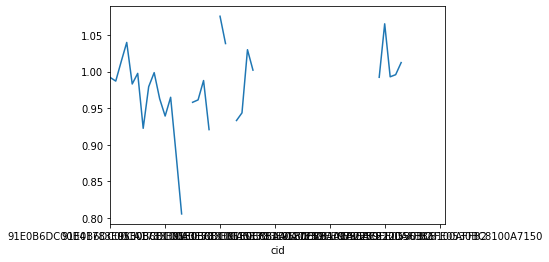

In [188]:
(power / lag365).mean(1).plot()

In [197]:
np.isnan(lag365).sum(1)

array([ 366,  755,  755,  857,  790,  899,  943,  956,  959,  974,  980,
        987,  986,  994, 1082, 1026, 1034, 1028, 1055, 1082, 1067, 1063,
       1082, 1058, 1058, 1067, 1067, 1082, 1082, 1082, 1082, 1082, 1082,
       1082, 1082, 1082, 1082, 1082, 1082, 1082, 1082, 1082, 1082, 1082,
       1082, 1082, 1082, 1082, 1082,  366,  857,  847,  905,  857,  791,
        922, 1082, 1082, 1082, 1082, 1082, 1082])

In [198]:
power.isnull().sum(1)

cid
91E0B6DC00B41783E0530BC8100A0E30      0
91E0B6DC00B51783E0530BC8100A0E30    389
91E0B6DC00B91783E0530BC8100A0E30    389
91E0B6DC00BA1783E0530BC8100A0E30    491
91E0B6DC00BB1783E0530BC8100A0E30    424
                                   ... 
91E0C8BAA1C5259EE0530BC8100AFFB2    722
91E0C8BAA1CB259EE0530BC8100AFFB2    792
91E1E413742C0582E0530BC8100A3E6E    822
9795AE222D56386FE0530BC8100A7150    825
9AC089DEFCF45804E0530BC8100A23FC    969
Length: 62, dtype: int64

In [19]:
daily_analysis = SeriesAnalysisModel(power.T.resample("D").mean().T.values)

In [132]:
corr = daily_analysis.get_autocorr(np.arange(1,400), threshold=1.5)

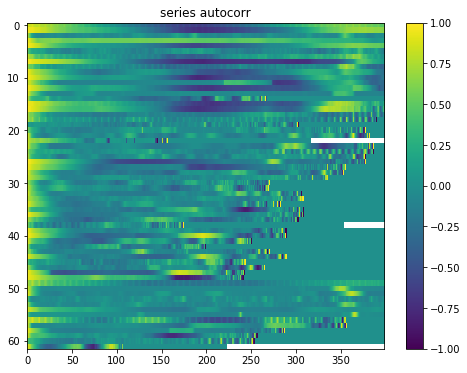

In [135]:
daily_analysis.plot_autocorr(corr.T)

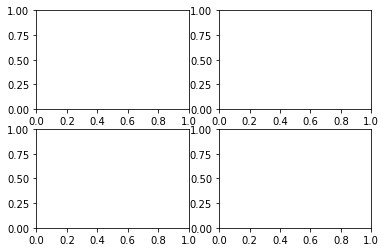

In [174]:
plt.subplots(2,2 )
plt.subplot(221)
plt.subplot(223)

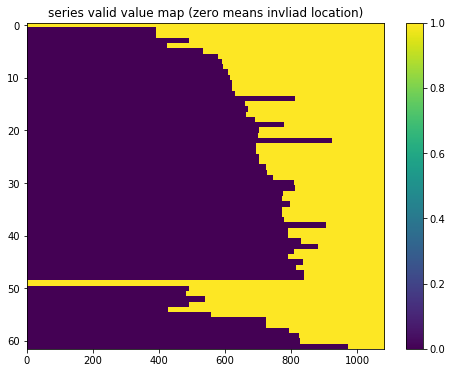

In [139]:
daily_analysis.plot_valid()

In [175]:
data

NameError: name 'data' is not defined

In [160]:
np.argmax(corr, 0)

array([  0,   0,   0,   0,   0,   0,   0,   0, 356,   0,   0,   0,   0,
         0, 265,   0,   0,   0, 384, 301, 377, 381, 317, 386,   0, 376,
       377, 355, 352, 334, 270, 269,   0, 308, 282, 306,   0,   0, 353,
         0, 288,   0,   0, 270, 289, 243, 264,   0,   0,   0,   0,   0,
         0,   0,   0, 364,   0, 356, 286,   0, 251, 223], dtype=int64)

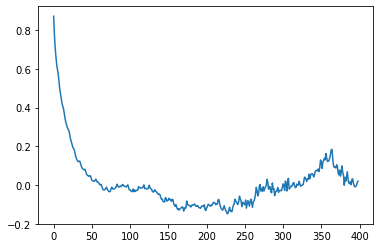

In [168]:
plt.plot(np.nan_to_num(corr).mean(1))

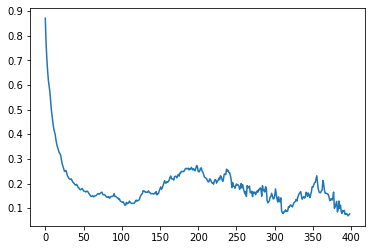

In [170]:
plt.plot(np.nan_to_num(np.abs(corr)).mean(1))

In [156]:
np.argmin(corr, 1)

array([192, 192, 380, 387, 185, 326, 184, 195, 395, 234, 190, 281, 200,
       398, 267, 207, 190, 394, 389, 302, 375, 371, 317, 331, 386, 377,
       376, 350, 351, 335, 267, 264, 305, 294, 281, 308, 308, 302, 353,
       289, 289, 250, 199, 268, 284, 227, 256, 242, 241, 135, 398, 327,
       332, 334, 176, 212, 355, 354, 282, 256, 253, 223], dtype=int64)

In [153]:
np.argmax(corr[0])

0

In [154]:
corr[0]

array([ 0.89552756,  0.85606569,  0.84997172,  0.84238578,  0.83892275,
        0.85753067,  0.89143973,  0.83752983,  0.80830071,  0.7991499 ,
        0.79425134,  0.78914804,  0.80759623,  0.83576606,  0.79288098,
        0.76856677,  0.75606456,  0.75399977,  0.74536763,  0.76021726,
        0.7867101 ,  0.74705979,  0.7242275 ,  0.71065238,  0.704704  ,
        0.69733028,  0.72383742,  0.74109328,  0.6966305 ,  0.67357984,
        0.65222259,  0.64738919,  0.63407651,  0.65759994,  0.6745351 ,
        0.62693007,  0.60723366,  0.59265957,  0.58644399,  0.57752013,
        0.59437543,  0.61117468,  0.56683629,  0.54482468,  0.53404544,
        0.52484883,  0.51579453,  0.53064569,  0.54081349,  0.50208823,
        0.47703075,  0.46079673,  0.4498931 ,  0.44662689,  0.46144874,
        0.47636497,  0.43983109,  0.4083859 ,  0.39199449,  0.38300762,
        0.3785096 ,  0.39386774,  0.41023624,  0.37407784,  0.3397511 ,
        0.31953575,  0.31126209,  0.30187325,  0.31747603,  0.32

In [28]:
im

In [17]:
power.shape[1] / power.shape[0]

12984.0

In [12]:
power.shape[1] / power.shape[0]

418.83870967741933

In [16]:
power

data_time,2017-04-30 00:00:00,2017-04-30 01:00:00,2017-04-30 02:00:00,2017-04-30 03:00:00,2017-04-30 04:00:00,2017-04-30 05:00:00,2017-04-30 06:00:00,2017-04-30 07:00:00,2017-04-30 08:00:00,2017-04-30 09:00:00,...,2020-04-15 14:00:00,2020-04-15 15:00:00,2020-04-15 16:00:00,2020-04-15 17:00:00,2020-04-15 18:00:00,2020-04-15 19:00:00,2020-04-15 20:00:00,2020-04-15 21:00:00,2020-04-15 22:00:00,2020-04-15 23:00:00
cid,,,,,,,,,,,,,,,,,,,,,
91E0B6DC00B41783E0530BC8100A0E30,9.292928,9.3268,9.30424,9.267823,9.177518,9.093689,8.976601,9.014201,9.044114,9.073157,...,9.656942,9.643891,9.650329,9.694016,9.631585,9.558167,9.479534,9.326953,8.629712,8.505145
91E0B6DC00B51783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.354836,9.331511,9.381401,9.448442,9.514657,9.566265,9.534905,9.418885,8.291041,7.909200
